In [249]:
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
import math as mt
import numpy as np
from scipy.optimize import linprog
import scipy.optimize as opt

In [273]:
VS = {'PV': 0, 'Wind': 0, 'BESS': 0, 'PV + Wind': 100, 'PV + BESS': 0, 'Wind + BESS': 0,  'PV + Wind + BESS': 200}
# convert strings to tuples removing spaces and split by +
VS = {tuple(k.replace(' ', '').split('+')): v for k, v in VS.items() if type(k) is str}
# VS[()] = 0  # empty coalition
VS = {frozenset(k): v for k, v in VS.items()}
my_names = ['PV', 'Wind', 'BESS']
VS

{frozenset({'PV'}): 0,
 frozenset({'Wind'}): 0,
 frozenset({'BESS'}): 0,
 frozenset({'PV', 'Wind'}): 100,
 frozenset({'BESS', 'PV'}): 0,
 frozenset({'BESS', 'Wind'}): 0,
 frozenset({'BESS', 'PV', 'Wind'}): 200}

# Game Theory

## Convexity

In [189]:
import pandas as pd
from src.game_theory_helpers import powerset, is_convex_game, check_convexity_grand_coalition, get_loo, get_shapley_value, get_nash_bargaining_solution

In [190]:
players = ['A', 'B', 'C']
v = {
    (): 0,
    ('A',): 0,
    ('B',): 0,
    ('C',): 0,
    ('A', 'B'): 100,
    ('A', 'C'): 0,
    ('B', 'C'): 0,
    ('A', 'B', 'C'): 200
}
# convert v to frozenset
v_frozen = {frozenset(k): val for k, val in v.items()}

In [191]:
def get_banzhaf_value(v: dict, players: list, normalized=True) -> dict:
    """
    get Banzhaf values for each player

    v: Characteristic function of the game, must be defined for EVERY coalition
        {frozenset -> float}
    players: list of players
    """
    factor = 1 / (2 ** (len(players) - 1))
    banzhaf_values = {p: 0 for p in players}
    for S in powerset(players):
        if S:  # skip 
            for p in S:
                subset_wo_p = frozenset(c for c in S if c != p)
                marginal_contribution = v.get(S) - v.get(subset_wo_p)
                banzhaf_values[p] += marginal_contribution
    banzhaf_values = {k: v * factor for k, v in banzhaf_values.items()}
    if normalized:
        total_banzhaf = sum(banzhaf_values.values())
        reward = v[frozenset(players)]
        if total_banzhaf > 0:
            banzhaf_values = {k: v * (reward / total_banzhaf) for k, v in banzhaf_values.items()}
    return banzhaf_values

In [193]:
get_banzhaf_value(v_frozen, players)

{'A': 85.71428571428571, 'B': 85.71428571428571, 'C': 28.57142857142857}

In [194]:
# test
is_convex_game(v_frozen, players)
check_convexity_grand_coalition(v_frozen, players)
print(get_loo(v_frozen, players))
print(get_shapley_value(v_frozen, players))
print(get_nash_bargaining_solution(v_frozen, players))

    Grand-Coalition Convexity holds
        Max benefit: 200.00, Min benefit: 100.00
{'A': 80.0, 'B': 80.0, 'C': 40.0}
{'A': 83.33333333333334, 'B': 83.33333333333334, 'C': 33.333333333333336}
{'A': 66.666666738125, 'B': 66.66666673812502, 'C': 66.66666652375004}


In [195]:
def print_2f_dict(d: dict):
    final_print = ''
    for k, v in d.items():
        final_print += f"{k}: {v:.2f}, "
    return final_print

## Define Plot Function

In [196]:
import matplotlib as mpl

In [197]:
# Get the Tab20 colormap
cmap = plt.cm.get_cmap("tab20")

# Extract the first 4 colors
base_colors = [cmap(i) for i in range(8)]

# Create extended cycle: first full alpha, then alpha=0.5
colors = base_colors + [(r, g, b, 0.5) for (r, g, b, _) in base_colors]

# Set this as default color cycle
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

C:\Users\carlv\AppData\Local\Temp\ipykernel_34268\2708105729.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab20")


In [198]:
def add_shapely_nbs(df: pd.DataFrame, players: list,
                    add_LOO=False) -> pd.DataFrame:
    """
    Add shapely and nbs values to dataframe df, and optionally LOO

    df: Dataframe with values for each coalition
    players: list of players
    """
    new_index = pd.MultiIndex.from_product((df.index, ['value', 'shapley', 'nbs']))
    if add_LOO:
        new_index = pd.MultiIndex.from_product((df.index, ['value', 'shapley', 'nbs', 'loo']))
    df_new = pd.DataFrame(index=new_index, columns=df.columns)
    for idx, row in df.iterrows():
        df_new.loc[(idx, 'value')] = row
        v = {frozenset(k): val for k, val in row.items()}
        shapley, nbs = get_shapley_value(v, players), get_nash_bargaining_solution(v, players)
        df_new.loc[(idx, 'shapley'), list((k,) for k in shapley.keys())] = list(shapley.values())
        df_new.loc[(idx, 'nbs'), list((k,) for k in nbs.keys())] = list(nbs.values())
        if add_LOO:
            loo = get_loo(v, players)
            df_new.loc[(idx, 'loo'), list((k,) for k in loo.keys())] = list(loo.values())
    return df_new

In [199]:
def visualize_value_results(df_new, df_newstat, calc_convexity=True):
    players = list(str(x[0]) for x in df_new.columns[:3])
    # plot for each service value, shapely and nbs
    for service in df_new.index.get_level_values(0).unique():
        df_plot = df_new.loc[service]
        df_plot = df_plot.astype(float)
        df_plot = df_plot.transpose()
        df_plot.columns = [col + ' Dynamic PF' for col in df_plot.columns]
        # also add df_newstat values
        if df_newstat is not None:
            df_plot_stat = df_newstat.loc[service]
            df_plot_stat = df_plot_stat.astype(float)
            df_plot_stat = df_plot_stat.transpose()
            # remove value column as it is duplicate
            # df_plot_stat = df_plot_stat.loc[:, df_plot_stat.columns != 'value']
            df_plot_stat.columns = [col + ' Static PF' for col in df_plot_stat.columns]
            # combine
            df_plot_total = pd.concat([df_plot, df_plot_stat], axis=1)
        else:
            df_plot_total = df_plot
        df_plot_total = df_plot_total.reindex(sorted(df_plot_total.columns, reverse=True), axis=1)
        # 1st plot: only the players
        df_plot = df_plot_total.iloc[:len(players)]
        ax = df_plot.plot(kind='bar', figsize=(10, 6),
                        title=f'Service: {service} - Individual Value, Shapley and NBS', ylabel='Value in €')
        
        plt.grid()
        plt.ylim(df_plot.min().min(), df_plot.max().max()+3)
        plt.xticks(rotation=0)
        # show numbers above bars
        for p in ax.patches:
            if p.get_height() >= 0:
                ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2, 1.03 * p.get_height()),
                            ha='center', va='bottom', rotation=90, fontsize=10)
        plt.xticks(rotation=45, ha='right')
        plt.show()

        # 2nd plot: all coalitions
        plt.figure()
        # drop na columns
        df_plot = df_plot_total.dropna(axis=1, how='any')
        # add two new index rows: Grand-C Convex Game? and Convex Game?

        # add convexity where there is  empty coalition
        if calc_convexity:
            v1 = {frozenset(k): val for k, val in df_new.loc[service].loc['value'].items()}
            v1[frozenset()] = 0  # ensure empty coalition is present
            v2 = {frozenset(k): val for k, val in df_newstat.loc[service].loc['value'].items()}
            v2[frozenset()] = 0  # ensure empty coalition is present
            # create df and append
            df_plot = pd.concat([df_plot, pd.DataFrame(0, index=['Grand-C Convex Game?', 'Convex Game?'], columns=df_plot.columns)], axis=0)
            df_plot.loc['Grand-C Convex Game?', 'value Dynamic PF'] = float(check_convexity_grand_coalition(v1, players))
            df_plot.loc['Grand-C Convex Game?', 'value Static PF'] = float(check_convexity_grand_coalition(v2, players))
            # calculate total convexity
            df_plot.loc['Convex Game?', 'value Dynamic PF'] = float(is_convex_game(v1, players))
            df_plot.loc['Convex Game?', 'value Static PF'] = float(is_convex_game(v2, players))
        
        
        ax = df_plot.plot(kind='bar', figsize=(10, 6),
                        title=f'Service: {service} - Value of Coalitions', ylabel='Value in €')
        plt.grid()
        plt.xticks(rotation=0)
        # show numbers above bars
        for p in ax.patches:
            if p.get_height() >= 0:
                ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2, 1.03 * p.get_height()),
                            ha='center', va='bottom', rotation=90, fontsize=10)
        plt.xticks(rotation=45, ha='right')
        plt.ylim(0, df_plot.max().max()+3)
        plt.show()


## DVPP1

no stochastic production, just 1MW of PV, Wind, BESS each

**IO_dict =      {'PV': (get_pv_sys(), 'lpf', 1),
                'Wind': (get_wind_sys(), 'lpf', 1),
                'BESS': (get_bess_energy_sys(e_max=1.8), 'hpf', 1),
                }**

In [306]:
# load data
# df = pd.read_csv('pics/new/values.csv', index_col=0, header=[0,1,2])
df = pd.read_csv('pics/v1/values_dyn.csv', index_col=0, header=[0,1,2])
df.columns = [tuple(c for c in col if c!='nan') for col in df.columns.values]
players = list(str(x[0]) for x in df.columns[:3])

df[df < 0] = 0  # set values below zero to zero
df

,"(PV,)","(Wind,)","(BESS,)","(PV, Wind)","(PV, BESS)","(Wind, BESS)","(PV, Wind, BESS)"
FCR,12.37032,12.13886,0.00000,23.35187,12.37032,12.37032,24.74064
FFR,1.13156,0.89878,3.16838,1.91396,3.05199,3.05199,5.05647
FFR-FCR,4.73210,3.80625,0.00000,7.61250,11.67593,11.90740,20.11141
FCR-D,12.60178,12.60178,0.00000,25.20356,12.60178,12.60178,25.20356


In [307]:
# also load static pf values
dfstat = pd.read_csv('pics/v1/values_stat.csv', index_col=0, header=[0,1,2])
dfstat.columns = [tuple(c for c in col if c!='nan') for col in dfstat.columns.values]
dfstat[dfstat < 0] = 0  # set values below zero to zero
dfstat

,"(PV,)","(Wind,)","(BESS,)","(PV, Wind)","(PV, BESS)","(Wind, BESS)","(PV, Wind, BESS)"
FCR,12.37032,12.13886,0.00000,24.27771,6.12086,6.12086,16.40803
FFR,1.13156,0.89878,3.16838,2.03035,2.76101,2.47004,4.12535
FFR-FCR,4.73210,3.80625,0.00000,8.53835,6.12086,6.12086,16.40803
FCR-D,12.60178,12.60178,0.00000,25.20356,7.27817,7.27817,19.18557


In [308]:
df_new = add_shapely_nbs(df, players, add_LOO=True)
df_newstat = add_shapely_nbs(dfstat, players, add_LOO=True)

In [310]:
df_v1 = df_new.copy()
df_v1stat = df_newstat.copy()

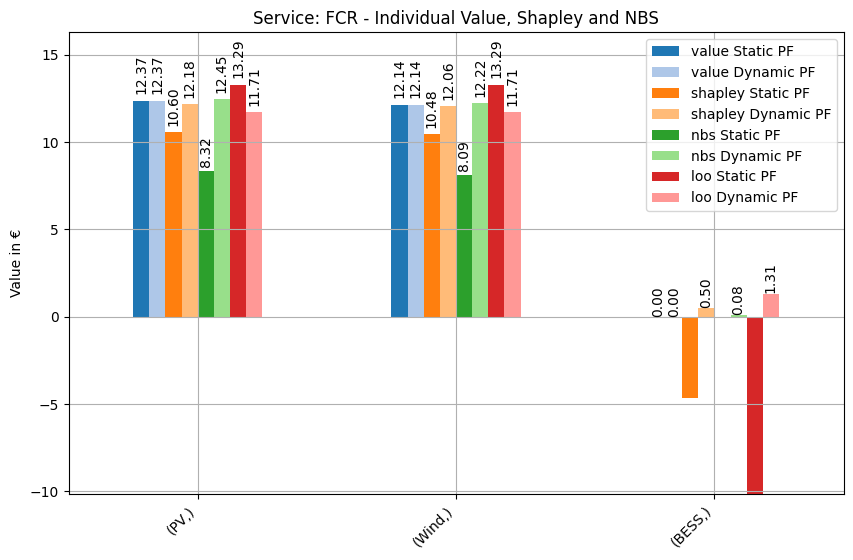

    Grand-Coalition Convexity holds
        Max benefit: 1.39, Min benefit: 0.00
    Game is not Grand-Coalition convex: frozenset({'PV'}), frozenset({'Wind', 'BESS'}), diff=-2.08
Game is not convex: frozenset({'PV'}), frozenset({'Wind'})
Game is not convex: frozenset({'PV'}), frozenset({'Wind'})


<Figure size 640x480 with 0 Axes>

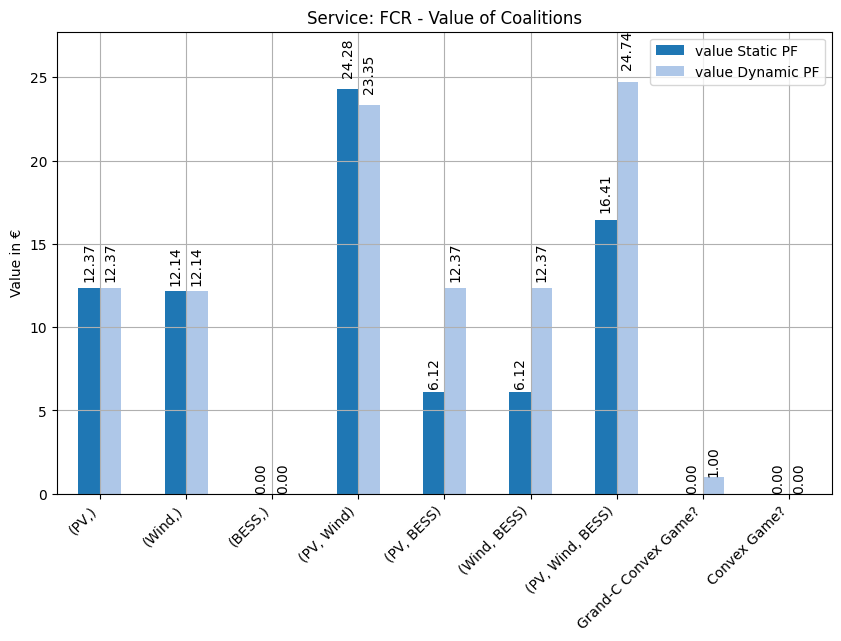

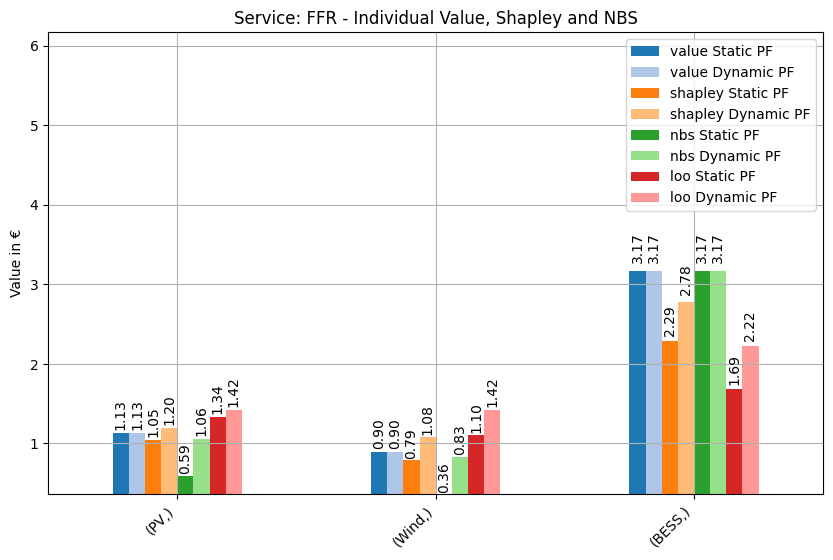

    Grand-Coalition Convexity holds
        Max benefit: 1.11, Min benefit: -0.03
    Game is not Grand-Coalition convex: frozenset({'BESS'}), frozenset({'PV', 'Wind'}), diff=-1.07
Game is not convex: frozenset({'PV'}), frozenset({'Wind'})
Game is not convex: frozenset({'PV'}), frozenset({'BESS'})


<Figure size 640x480 with 0 Axes>

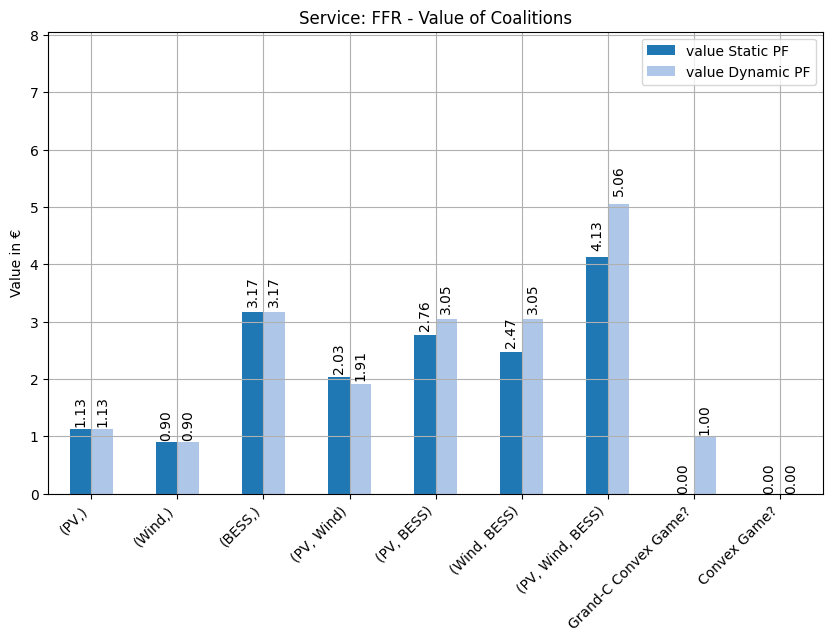

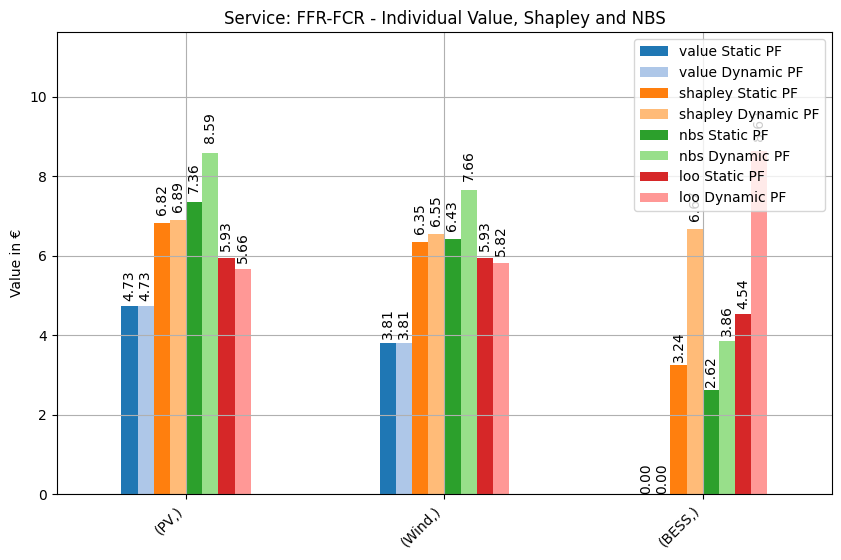

    Grand-Coalition Convexity holds
        Max benefit: 12.50, Min benefit: 3.47
    Grand-Coalition Convexity holds
        Max benefit: 7.87, Min benefit: 5.56
Game is not convex: frozenset({'PV'}), frozenset({'Wind'})


<Figure size 640x480 with 0 Axes>

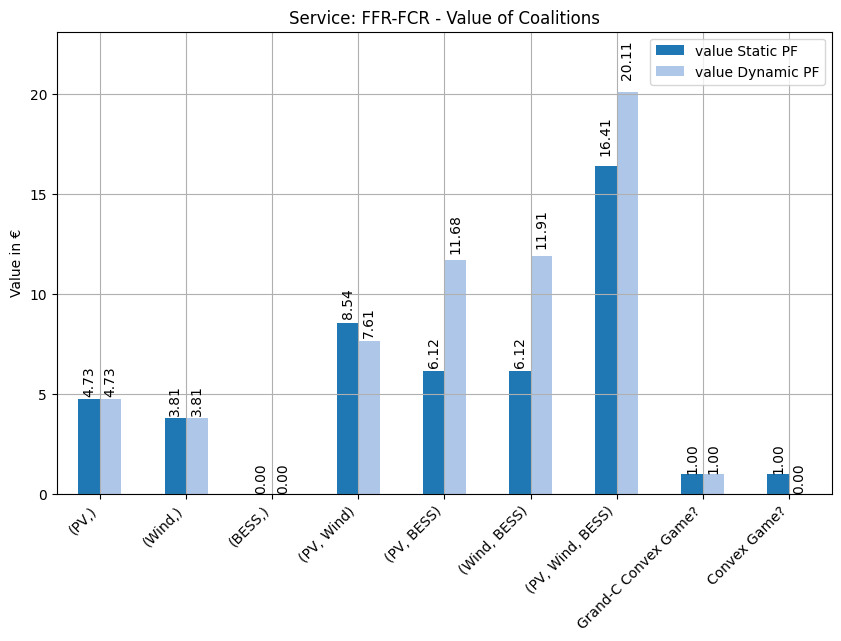

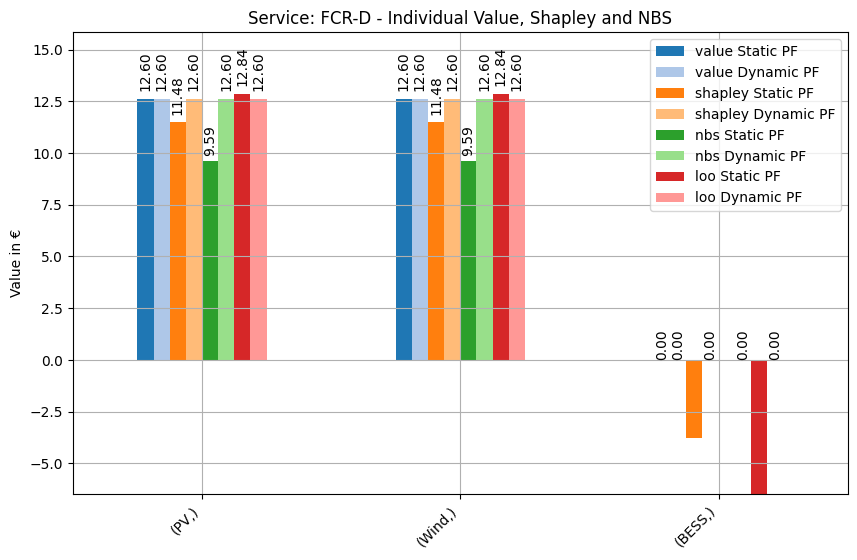

    Grand-Coalition Convexity holds
        Max benefit: 0.00, Min benefit: 0.00
    Game is not Grand-Coalition convex: frozenset({'PV'}), frozenset({'Wind', 'BESS'}), diff=-0.69
Game is not convex: frozenset({'PV'}), frozenset({'BESS'})


<Figure size 640x480 with 0 Axes>

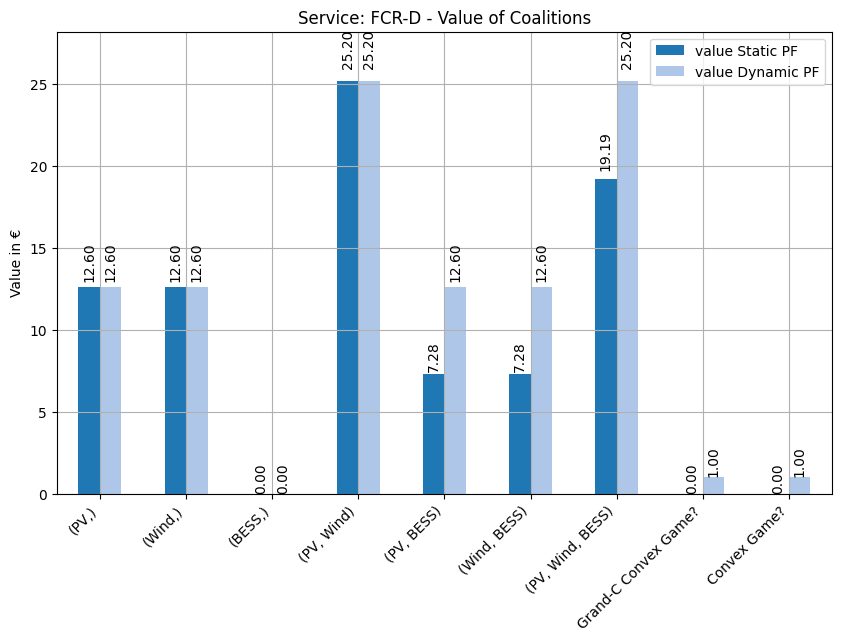

In [203]:
visualize_value_results(df_new, df_newstat)

In [204]:
# compute shapelt value for every row
for idx, row in df.iterrows():
    v = {frozenset(k): val for k, val in row.items()}
    v[frozenset()] = 0  # ensure empty coalition is present
    # print(f"{idx} LOO: {print_2f_dict(get_loo(v, players))}")
    # print(f"{idx} Shapely values: {print_2f_dict(get_shapley_value(v, players))}")
    # print(f"{idx} NBS: {print_2f_dict(get_nash_bargaining_solution(v, players))}")
    print(f"{idx} Dynamic PF:")
    is_convex_game(v, players)
    check_convexity_grand_coalition(v, players)

    # compare to static
    v_stat = {frozenset(k): val for k, val in dfstat.loc[idx].items()}
    v_stat[frozenset()] = 0  # ensure empty coalition is present
    # print(f"{idx} Static PF Shapely values: {print_2f_dict(get_shapley_value(v_stat, players))}")
    # print(f"{idx} Static PF NBS: {print_2f_dict(get_nash_bargaining_solution(v_stat, players))}")
    print(f"{idx} Static PF:")
    is_convex_game(v_stat, players)
    check_convexity_grand_coalition(v_stat, players)
    print('---')


FCR Dynamic PF:
Game is not convex: frozenset({'PV'}), frozenset({'Wind'})
    Grand-Coalition Convexity holds
        Max benefit: 1.39, Min benefit: 0.00
FCR Static PF:
Game is not convex: frozenset({'PV'}), frozenset({'Wind'})
    Game is not Grand-Coalition convex: frozenset({'PV'}), frozenset({'Wind', 'BESS'}), diff=-2.08
---
FFR Dynamic PF:
Game is not convex: frozenset({'PV'}), frozenset({'Wind'})
    Grand-Coalition Convexity holds
        Max benefit: 1.11, Min benefit: -0.03
FFR Static PF:
Game is not convex: frozenset({'PV'}), frozenset({'BESS'})
    Game is not Grand-Coalition convex: frozenset({'BESS'}), frozenset({'PV', 'Wind'}), diff=-1.07
---
FFR-FCR Dynamic PF:
Game is not convex: frozenset({'PV'}), frozenset({'Wind'})
    Grand-Coalition Convexity holds
        Max benefit: 12.50, Min benefit: 3.47
FFR-FCR Static PF:
    Grand-Coalition Convexity holds
        Max benefit: 7.87, Min benefit: 5.56
---
FCR-D Dynamic PF:
    Grand-Coalition Convexity holds
        Max be

## DVPP2

stochastic production of PV, BESS Wind with 

IO_dict =      {'PV': (get_pv_sys(), 'lpf', 2),
                'Wind': (get_wind_sys(), 'lpf', 1.5),
                'BESS': (get_bess_energy_sys(e_max=1.8), 'hpf', 1),
                }

In [311]:
# load data
# df = pd.read_csv('pics/new/values.csv', index_col=0, header=[0,1,2])
df = pd.read_csv('pics/v2/values_dyn.csv', index_col=0, header=[0,1,2])
df.columns = [tuple(c for c in col if c!='nan') for col in df.columns.values]

df[df < 0] = 0  # set values below zero to zero
# combine 1st col and index to MultiIndex
df.index = pd.MultiIndex.from_arrays([df.index, df.iloc[:, 0]], names=['Service', 'Scenario'])
df.drop(df.columns[0], axis=1, inplace=True)  # drop first column
players = list(str(x[0]) for x in df.columns[:3])
df.head()

(PV,)   (Wind,)  (BESS,)  (PV, Wind)  (PV, BESS)  \
Service Scenario                                                        
FCR     0         11.44763   6.39123      0.0    16.95253    11.44763   
        1          0.00000   5.49567      0.0     5.28609     0.00000   
        2         20.72209  24.59136      0.0    43.21245    20.72209   
        3         15.20172  11.24294      0.0    25.16259    15.20172   
        4         11.54099   7.23736      0.0    18.06223    11.76105   

                  (Wind, BESS)  (PV, Wind, BESS)  
Service Scenario                                  
FCR     0              6.51309          17.96072  
        1              5.60046           5.60046  
        2             25.06026          45.78235  
        3             11.45732          26.65904  
        4              7.37537          19.13642

In [312]:
# also load static pf values
dfstat = pd.read_csv('pics/v2/values_stat.csv', index_col=0, header=[0,1,2])
dfstat.columns = [tuple(c for c in col if c!='nan') for col in dfstat.columns.values]
players = list(dfstat.columns[-2])
dfstat[dfstat < 0] = 0  # set values below zero to zero
# combine 1st col and index to MultiIndex
dfstat.index = pd.MultiIndex.from_arrays([dfstat.index, df.iloc[:, 0]], names=['Service', 'Scenario'])
dfstat.drop(dfstat.columns[0], axis=1, inplace=True)  # drop first column
players = list(str(x[0]) for x in dfstat.columns[:3])
dfstst_mean = dfstat.groupby(level=0).mean()

In [313]:
# mean over all scenarios
df_mean = df.groupby('Service').mean()
# check for convexity, shapely and nbs for mean values
for idx, row in df_mean.iterrows():
    v = {frozenset(k): val for k, val in row.items()}
    v[frozenset()] = 0  # ensure empty coalition is present
    # print(f"{idx} Shapely values: {print_2f_dict(get_shapley_value(v, players))}")
    # print(f"{idx} NBS: {print_2f_dict(get_nash_bargaining_solution(v, players))}")
    print(f"{idx} Dynamic PF:")
    is_convex_game(v, players)
    check_convexity_grand_coalition(v, players)

FCR Dynamic PF:
Game is not convex: frozenset({'PV'}), frozenset({'Wind'})
    Grand-Coalition Convexity holds
        Max benefit: 1.03, Min benefit: 0.02
FCR-D Dynamic PF:
Game is not convex: frozenset({'PV'}), frozenset({'Wind'})
    Game is not Grand-Coalition convex: frozenset({'PV'}), frozenset({'Wind', 'BESS'}), diff=-0.24
FFR Dynamic PF:
Game is not convex: frozenset({'PV'}), frozenset({'Wind'})
    Game is not Grand-Coalition convex: frozenset({'BESS'}), frozenset({'PV', 'Wind'}), diff=-0.21
FFR-FCR Dynamic PF:
Game is not convex: frozenset({'PV'}), frozenset({'Wind'})
    Grand-Coalition Convexity holds
        Max benefit: 8.53, Min benefit: 1.43


In [314]:
df_new = add_shapely_nbs(df_mean, players, add_LOO=True)
df_newstat = add_shapely_nbs(dfstst_mean, players, add_LOO=True)

In [315]:
df_v2 = df_new.copy()
df_v2stat = df_newstat.copy()

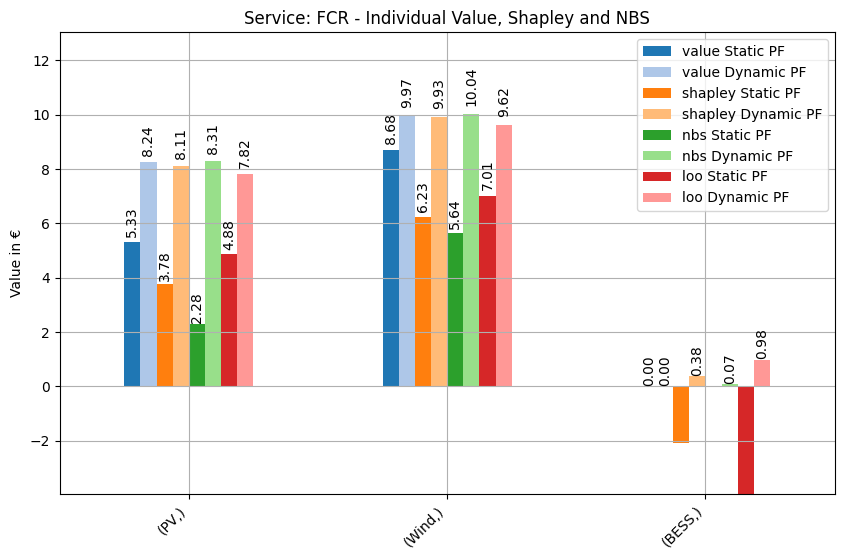

    Grand-Coalition Convexity holds
        Max benefit: 1.03, Min benefit: 0.02
    Game is not Grand-Coalition convex: frozenset({'PV'}), frozenset({'Wind', 'BESS'}), diff=-1.80
Game is not convex: frozenset({'PV'}), frozenset({'Wind'})
Game is not convex: frozenset({'PV'}), frozenset({'Wind'})


<Figure size 640x480 with 0 Axes>

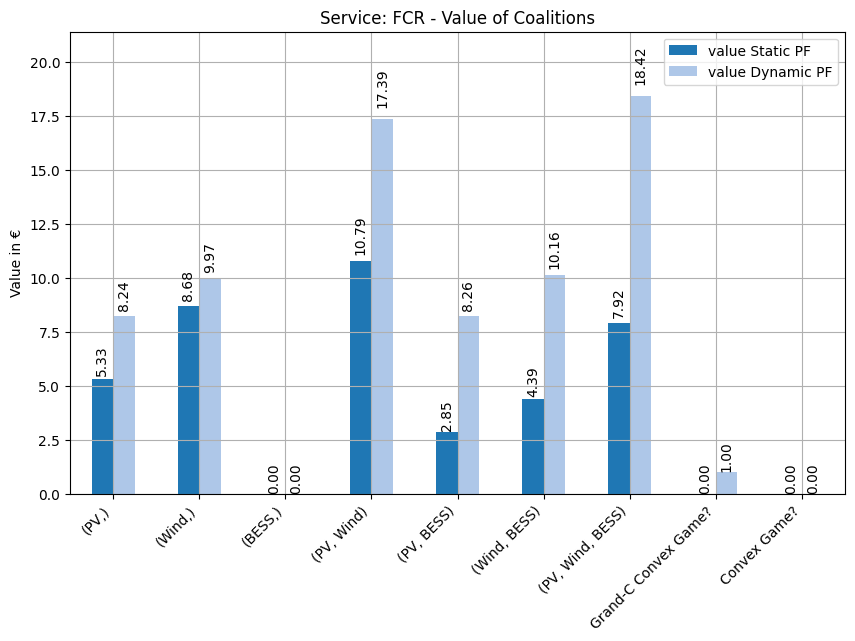

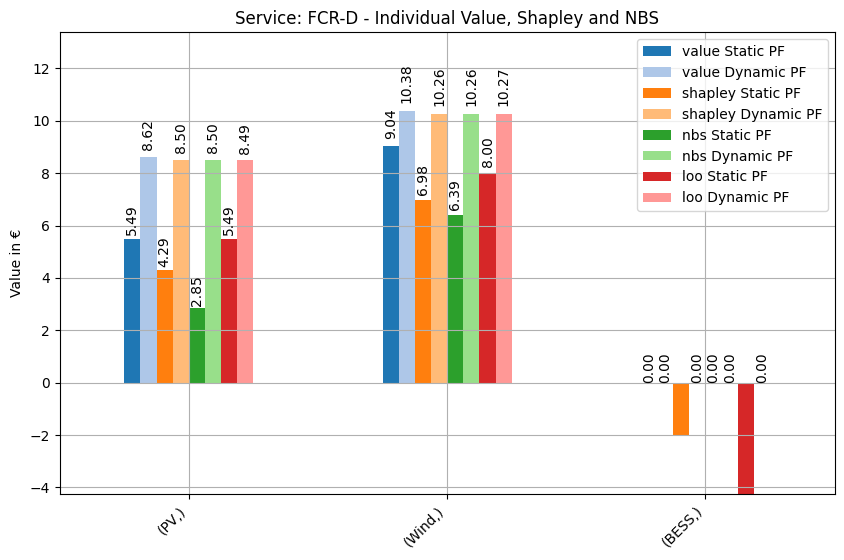

    Game is not Grand-Coalition convex: frozenset({'PV'}), frozenset({'Wind', 'BESS'}), diff=-0.24
    Game is not Grand-Coalition convex: frozenset({'PV'}), frozenset({'Wind', 'BESS'}), diff=-1.47
Game is not convex: frozenset({'PV'}), frozenset({'Wind'})
Game is not convex: frozenset({'PV'}), frozenset({'Wind'})


<Figure size 640x480 with 0 Axes>

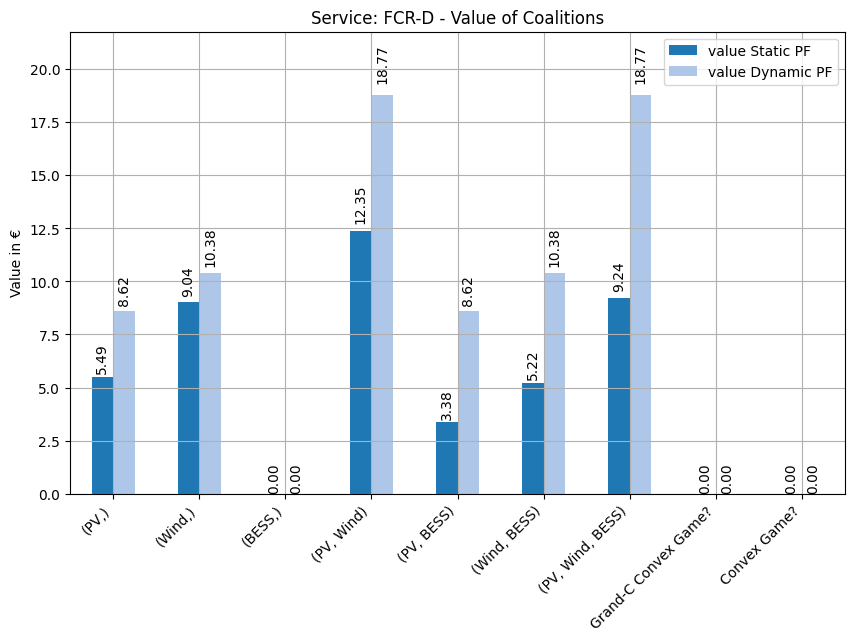

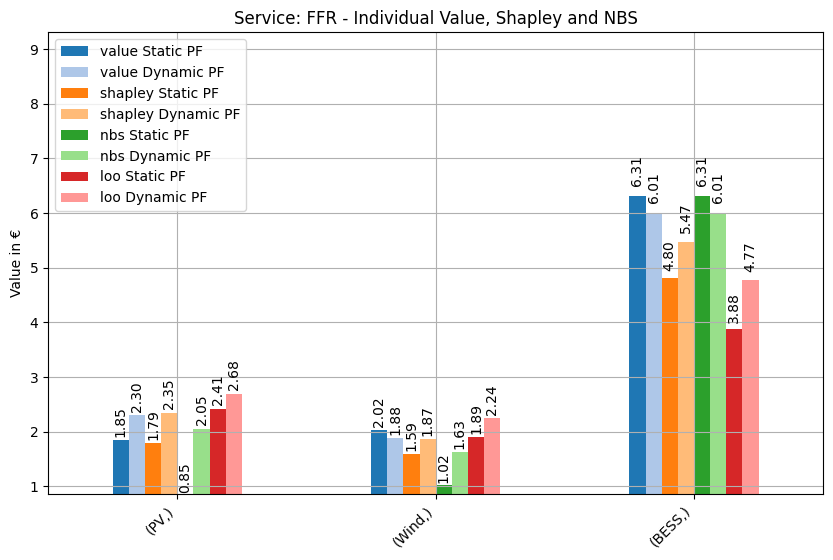

    Game is not Grand-Coalition convex: frozenset({'BESS'}), frozenset({'PV', 'Wind'}), diff=-0.21
    Game is not Grand-Coalition convex: frozenset({'BESS'}), frozenset({'PV', 'Wind'}), diff=-2.14
Game is not convex: frozenset({'PV'}), frozenset({'Wind'})
Game is not convex: frozenset({'PV'}), frozenset({'BESS'})


<Figure size 640x480 with 0 Axes>

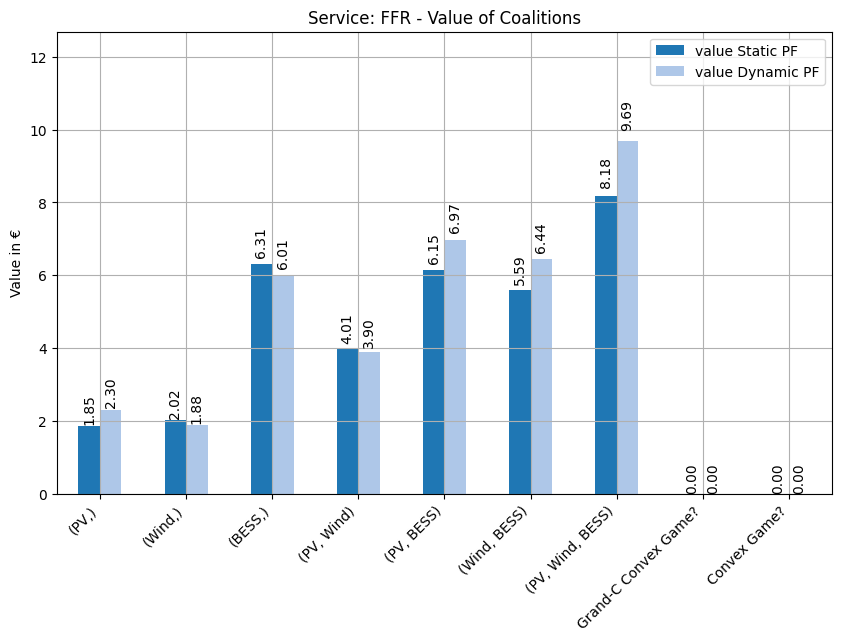

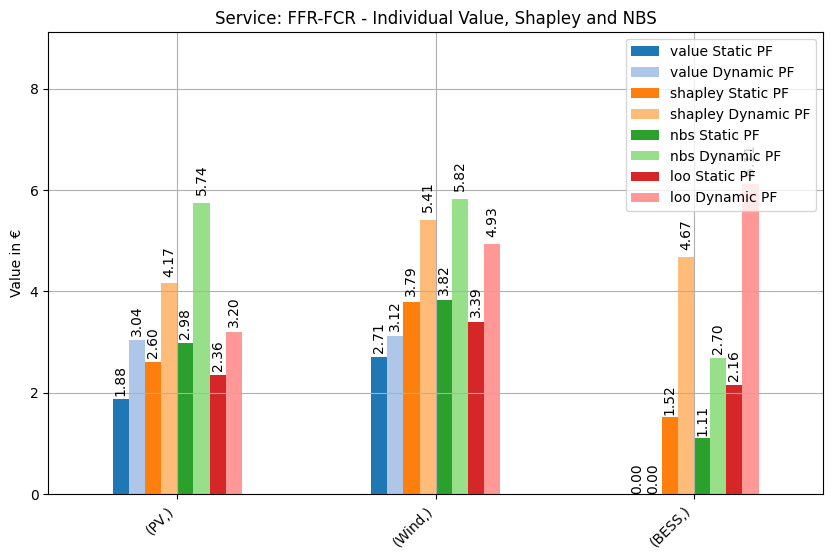

    Grand-Coalition Convexity holds
        Max benefit: 8.53, Min benefit: 1.43
    Grand-Coalition Convexity holds
        Max benefit: 3.23, Min benefit: 1.65
Game is not convex: frozenset({'PV'}), frozenset({'Wind'})


<Figure size 640x480 with 0 Axes>

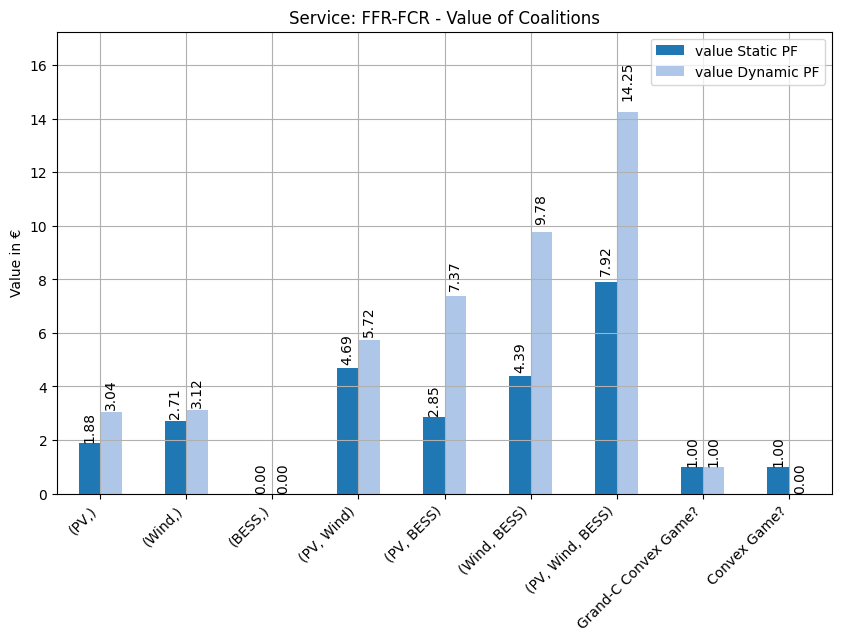

In [209]:
# visualize:
visualize_value_results(df_new, df_newstat)

## DVPP3

no stochastic production, 1MW of

**IO_dict = {'Hydro': (get_hydro_tf(), 'lpf', 1),
                'BESS': (get_bess_energy_sys(e_max=1.8), 'hpf', 1),
                'SC': (get_sc_io_sys(t_drop=5), 'hpf', 1),
                }**

In [210]:
# load data
df = pd.read_csv('pics/v3/values_dyn.csv', index_col=0, header=[0,1,2])
df.columns = [tuple(c for c in col if c!='nan') for col in df.columns.values]
players = [str(x[0]) for x in df.columns[:3]]
df[df < 0] = 0  # set values below zero to zero
df

,"(Hydro,)","(BESS,)","(SC,)","(Hydro, BESS)","(Hydro, SC)","(BESS, SC)","(Hydro, BESS, SC)"
FCR,0.0,0.00000,0.00000,12.37032,1.26018,0.00000,12.37032
FFR,0.0,3.16838,0.84059,2.99379,1.48073,3.16838,2.99379
FFR-FCR,0.0,0.00000,0.00000,6.58379,3.34333,0.00000,6.58379
FCR-D,0.0,0.00000,0.00000,7.50963,2.41748,0.00000,7.50963


In [211]:
# also load static pf values
dfstat = pd.read_csv('pics/v3/values_stat.csv', index_col=0, header=[0,1,2])
dfstat.columns = [tuple(c for c in col if c!='nan') for col in dfstat.columns.values]
players_stat = players
dfstat[dfstat < 0] = 0  # set values below zero to zero
dfstat

,"(Hydro,)","(BESS,)","(SC,)","(Hydro, BESS)","(Hydro, SC)","(BESS, SC)","(Hydro, BESS, SC)"
FCR,0.0,0.00000,0.00000,12.37032,6.12086,6.12086,8.20402
FFR,0.0,3.16838,0.84059,1.24795,1.24795,2.41185,1.88809
FFR-FCR,0.0,0.00000,0.00000,5.19502,3.80625,6.12086,7.04671
FCR-D,0.0,0.00000,0.00000,12.60178,7.04671,7.27817,9.59278


In [212]:
# check convexity
for idx, row in df.iterrows():
    v = {frozenset(k): val for k, val in row.items()}
    v[frozenset()] = 0  # ensure empty coalition is present
    # print(f"{idx} Shapely values: {print_2f_dict(get_shapley_value(v, players))}")
    # print(f"{idx} NBS: {print_2f_dict(get_nash_bargaining_solution(v, players))}")
    is_convex_game(v, players)
    check_convexity_grand_coalition(v, players)

    # compare to static
    v_stat = {frozenset(k): val for k, val in dfstat.loc[idx].items()}
    v_stat[frozenset()] = 0  # ensure empty coalition is present
    # print(f"{idx} Static PF Shapely values: {print_2f_dict(get_shapley_value(v_stat, players_stat))}")
    # print(f"{idx} Static PF NBS: {print_2f_dict(get_nash_bargaining_solution(v_stat, players_stat))}")
    is_convex_game(v_stat, players_stat)
    check_convexity_grand_coalition(v_stat, players_stat)
    print('---')

Game is not convex: frozenset({'Hydro', 'BESS'}), frozenset({'Hydro', 'SC'})
    Grand-Coalition Convexity holds
        Max benefit: 12.37, Min benefit: 0.00
Game is not convex: frozenset({'SC'}), frozenset({'Hydro', 'BESS'})
    Game is not Grand-Coalition convex: frozenset({'SC'}), frozenset({'Hydro', 'BESS'}), diff=-4.17
---
Game is not convex: frozenset({'Hydro'}), frozenset({'BESS'})
    Game is not Grand-Coalition convex: frozenset({'Hydro'}), frozenset({'BESS', 'SC'}), diff=-0.17
Game is not convex: frozenset({'Hydro'}), frozenset({'BESS'})
    Game is not Grand-Coalition convex: frozenset({'Hydro'}), frozenset({'BESS', 'SC'}), diff=-0.52
---
Game is not convex: frozenset({'Hydro', 'BESS'}), frozenset({'Hydro', 'SC'})
    Grand-Coalition Convexity holds
        Max benefit: 6.58, Min benefit: 0.00
Game is not convex: frozenset({'Hydro', 'BESS'}), frozenset({'Hydro', 'SC'})
    Grand-Coalition Convexity holds
        Max benefit: 3.24, Min benefit: 0.93
---
Game is not convex: f

In [213]:
df_new = add_shapely_nbs(df, players, add_LOO=True)
df_newstat = add_shapely_nbs(dfstat, players, add_LOO=True)

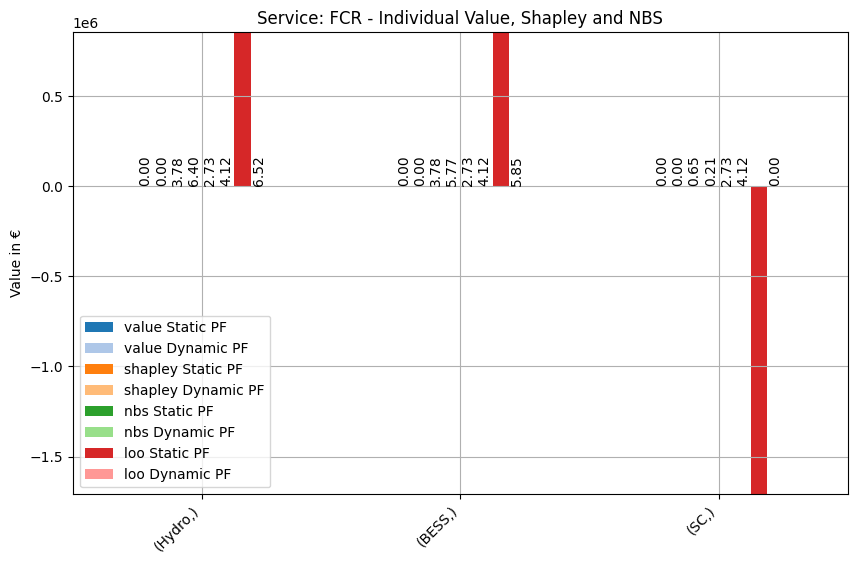

    Grand-Coalition Convexity holds
        Max benefit: 12.37, Min benefit: 0.00
    Game is not Grand-Coalition convex: frozenset({'SC'}), frozenset({'Hydro', 'BESS'}), diff=-4.17
Game is not convex: frozenset({'Hydro', 'BESS'}), frozenset({'Hydro', 'SC'})
Game is not convex: frozenset({'SC'}), frozenset({'Hydro', 'BESS'})


<Figure size 640x480 with 0 Axes>

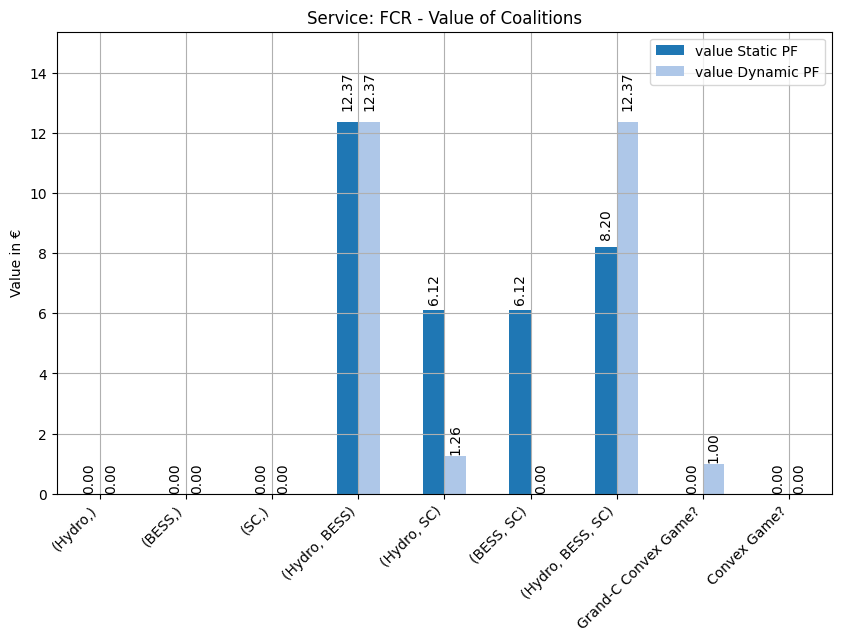

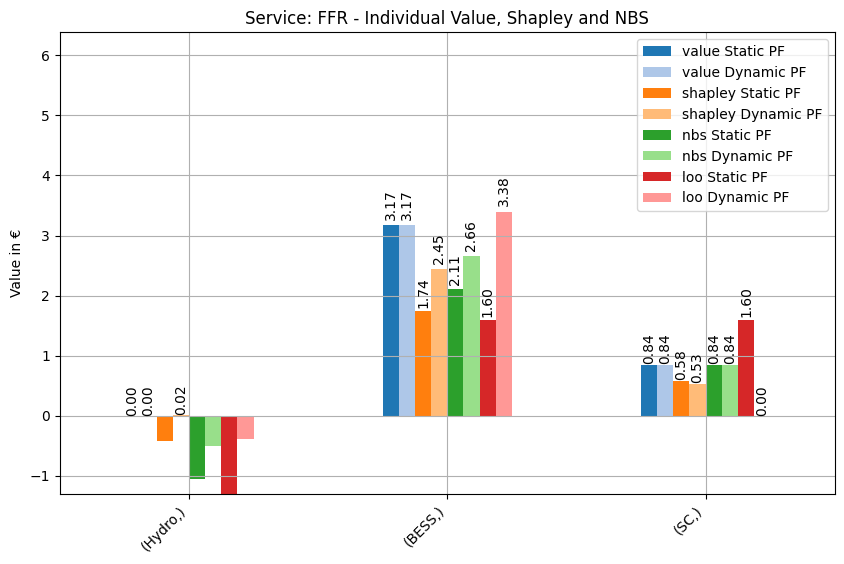

    Game is not Grand-Coalition convex: frozenset({'Hydro'}), frozenset({'BESS', 'SC'}), diff=-0.17
    Game is not Grand-Coalition convex: frozenset({'Hydro'}), frozenset({'BESS', 'SC'}), diff=-0.52
Game is not convex: frozenset({'Hydro'}), frozenset({'BESS'})
Game is not convex: frozenset({'Hydro'}), frozenset({'BESS'})


<Figure size 640x480 with 0 Axes>

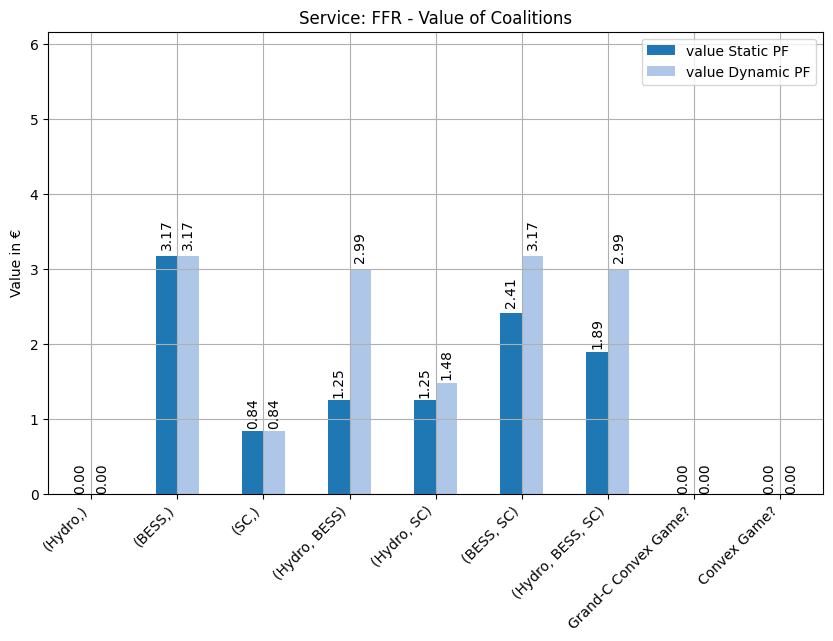

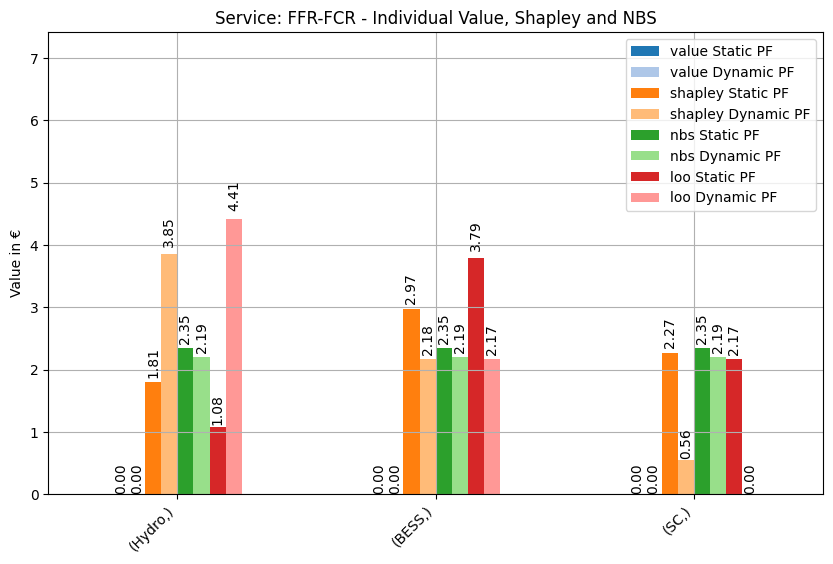

    Grand-Coalition Convexity holds
        Max benefit: 6.58, Min benefit: 0.00
    Grand-Coalition Convexity holds
        Max benefit: 3.24, Min benefit: 0.93
Game is not convex: frozenset({'Hydro', 'BESS'}), frozenset({'Hydro', 'SC'})
Game is not convex: frozenset({'Hydro', 'BESS'}), frozenset({'Hydro', 'SC'})


<Figure size 640x480 with 0 Axes>

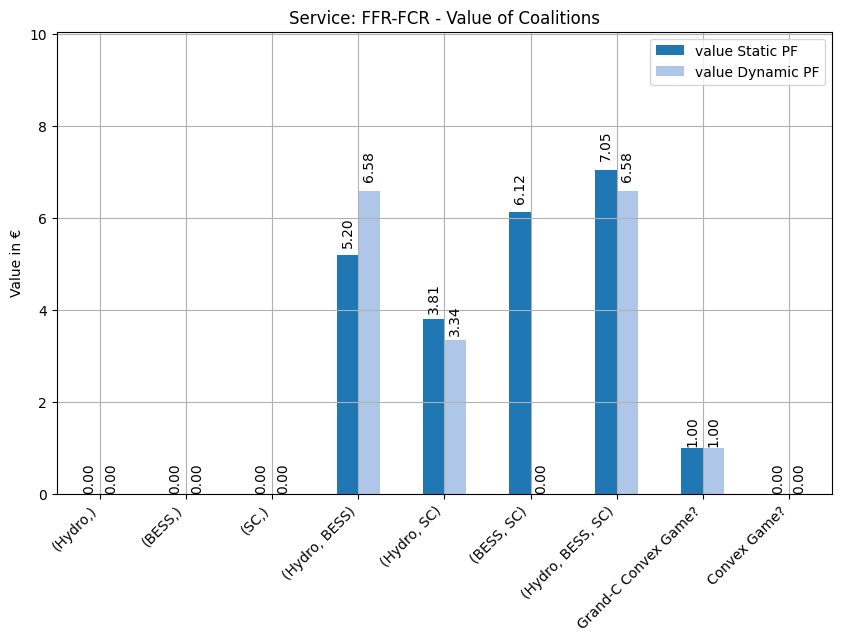

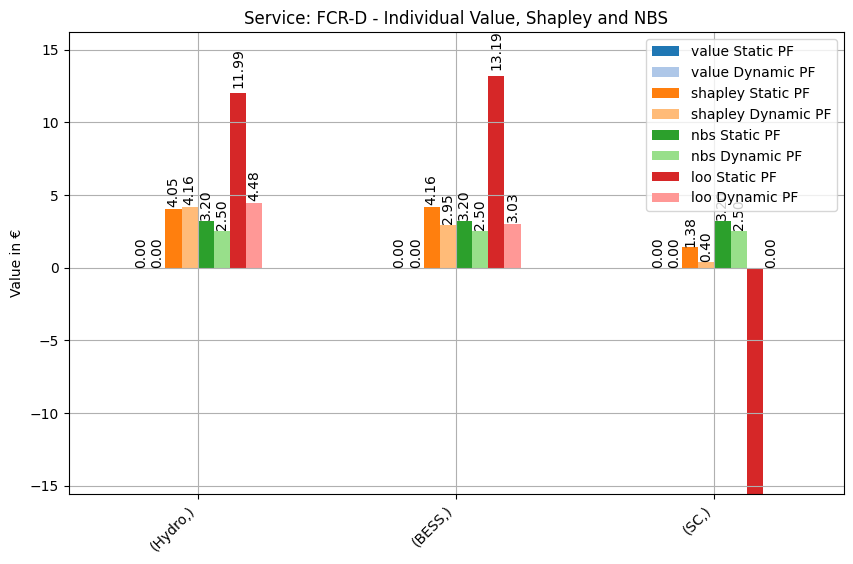

    Grand-Coalition Convexity holds
        Max benefit: 7.51, Min benefit: 0.00
    Game is not Grand-Coalition convex: frozenset({'SC'}), frozenset({'Hydro', 'BESS'}), diff=-3.01
Game is not convex: frozenset({'Hydro', 'BESS'}), frozenset({'Hydro', 'SC'})
Game is not convex: frozenset({'SC'}), frozenset({'Hydro', 'BESS'})


<Figure size 640x480 with 0 Axes>

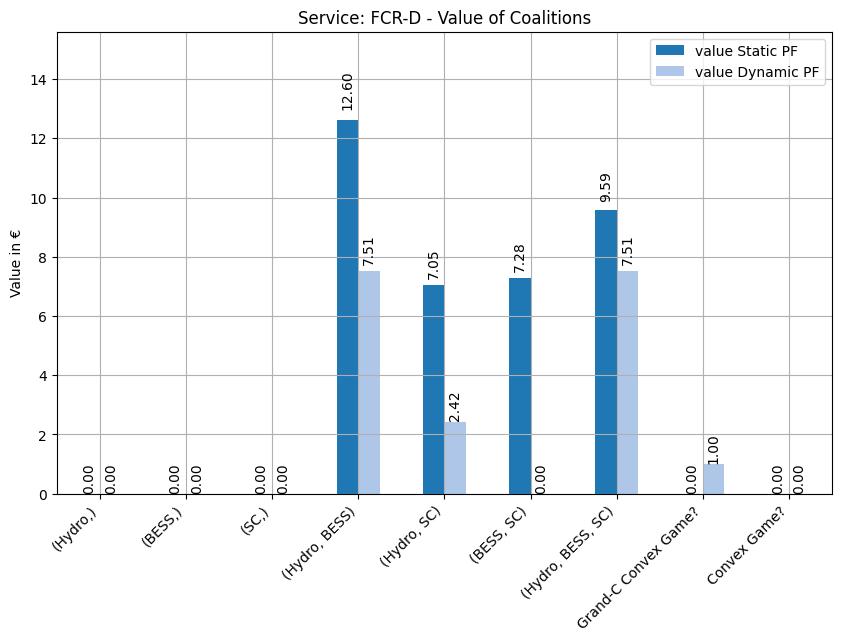

In [214]:
visualize_value_results(df_new, df_newstat)

## DVPP2A

Using adpative dynamic PF (ADPF) with setttings 

{'PV': (get_pv_sys(), 'lpf', 1),
                'Wind': (get_wind_sys(), 'lpf', 1),
                'BESS': (get_bess_energy_sys(e_max=1.8), 'hpf', 1),
                }
    
def adaptive_pv_func(t):
    return .3 + .7 * np.sin(t / 5)**2

def adaptive_wind_func(t):
    return .3 + .7 * np.cos(t / 5 + .5)**2

In [316]:
# load data
df = pd.read_csv('pics/v2A/values_dyn.csv', index_col=0, header=[0,1,2])
df.columns = [tuple(c for c in col if c!='nan') for col in df.columns.values]

df[df < 0] = 0  # set values below zero to zero
df

,"(PV,)","(Wind,)","(BESS,)","(PV, Wind)","(PV, BESS)","(Wind, BESS)","(PV, Wind, BESS)"
FCR,3.57479,3.57479,0.00000,11.31588,12.13886,11.67593,17.79680
FFR,1.01517,0.89878,3.16838,1.09923,3.11018,3.11018,4.24174
FFR-FCR,3.57479,3.57479,0.00000,4.37205,12.13886,3.57479,16.87095
FCR-D,4.26917,4.26917,0.00000,14.09342,5.19502,4.26917,21.03726


In [317]:
df_stat = pd.read_csv('pics/v2A/values_stat.csv', index_col=0, header=[0,1,2])
df_stat.columns = [tuple(c for c in col if c!='nan') for col in df_stat.columns.values]

df_stat[df_stat < 0] = 0  # set values below zero to zero
df_stat

,"(PV,)","(Wind,)","(BESS,)","(PV, Wind)","(PV, BESS)","(Wind, BESS)","(PV, Wind, BESS)"
FCR,3.57479,3.57479,0.00000,11.31588,3.11187,1.72310,8.07543
FFR,1.01517,0.89878,3.16838,1.09923,1.71351,1.94629,2.72868
FFR-FCR,3.57479,3.57479,0.00000,4.37205,1.72310,1.72310,8.07543
FCR-D,4.26917,4.26917,0.00000,14.09342,2.18602,2.18602,9.00127


In [318]:
players = list(str(x[0]) for x in df.columns[:3])

In [319]:
df_new = add_shapely_nbs(df, players, add_LOO=True)
df_newstat = add_shapely_nbs(df_stat, players, add_LOO=True)

In [320]:
df_v2A = df_new.copy()
df_v2Astat = df_newstat.copy()

In [219]:
# check convexity
for idx, row in df.iterrows():
    v = {frozenset(k): val for k, val in row.items()}
    v[frozenset()] = 0  # ensure empty coalition is present
    # print(f"{idx} LOO: {print_2f_dict(get_loo(v, players))}")
    # print(f"{idx} Shapely values: {print_2f_dict(get_shapley_value(v, players))}")
    # print(f"{idx} NBS: {print_2f_dict(get_nash_bargaining_solution(v, players))}")
    print(f"{idx} - Convexity")
    is_convex_game(v, players)
    check_convexity_grand_coalition(v, players)

FCR - Convexity
Game is not convex: frozenset({'PV', 'Wind'}), frozenset({'PV', 'BESS'})
    Grand-Coalition Convexity holds
        Max benefit: 6.48, Min benefit: 2.08
FFR - Convexity
Game is not convex: frozenset({'PV'}), frozenset({'Wind'})
    Grand-Coalition Convexity holds
        Max benefit: 0.23, Min benefit: -0.03
FFR-FCR - Convexity
Game is not convex: frozenset({'PV'}), frozenset({'Wind'})
    Grand-Coalition Convexity holds
        Max benefit: 12.50, Min benefit: 1.16
FCR-D - Convexity
    Grand-Coalition Convexity holds
        Max benefit: 12.50, Min benefit: 6.94


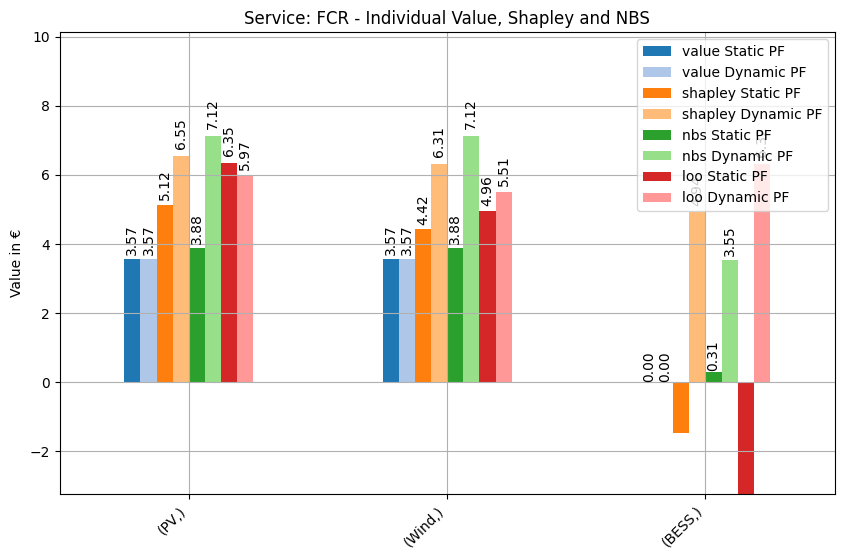

    Grand-Coalition Convexity holds
        Max benefit: 6.48, Min benefit: 2.08
    Game is not Grand-Coalition convex: frozenset({'BESS'}), frozenset({'PV', 'Wind'}), diff=-3.24
Game is not convex: frozenset({'PV', 'Wind'}), frozenset({'PV', 'BESS'})
Game is not convex: frozenset({'PV'}), frozenset({'BESS'})


<Figure size 640x480 with 0 Axes>

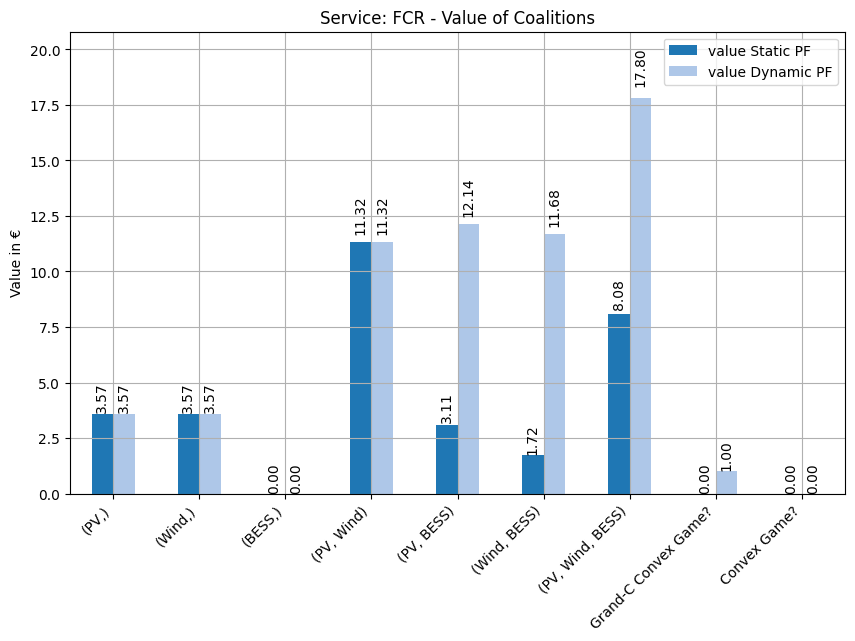

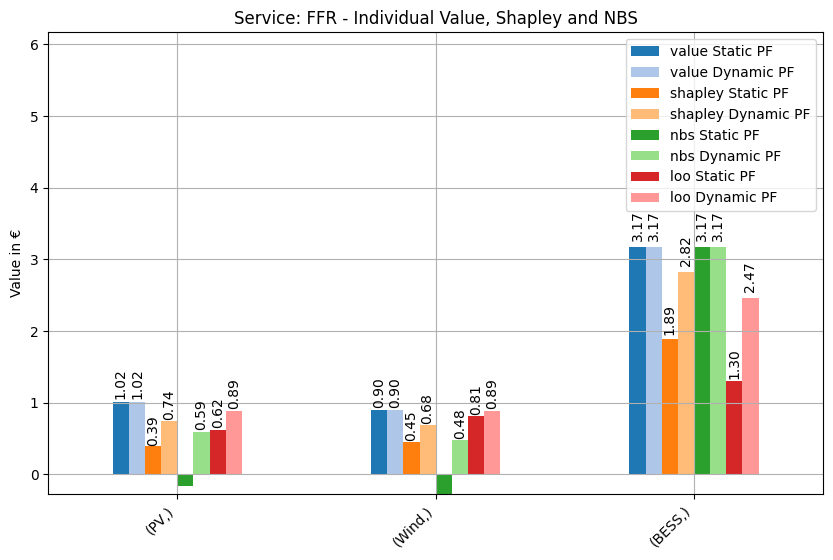

    Grand-Coalition Convexity holds
        Max benefit: 0.23, Min benefit: -0.03
    Game is not Grand-Coalition convex: frozenset({'PV'}), frozenset({'Wind', 'BESS'}), diff=-0.23
Game is not convex: frozenset({'PV'}), frozenset({'Wind'})
Game is not convex: frozenset({'PV'}), frozenset({'Wind'})


<Figure size 640x480 with 0 Axes>

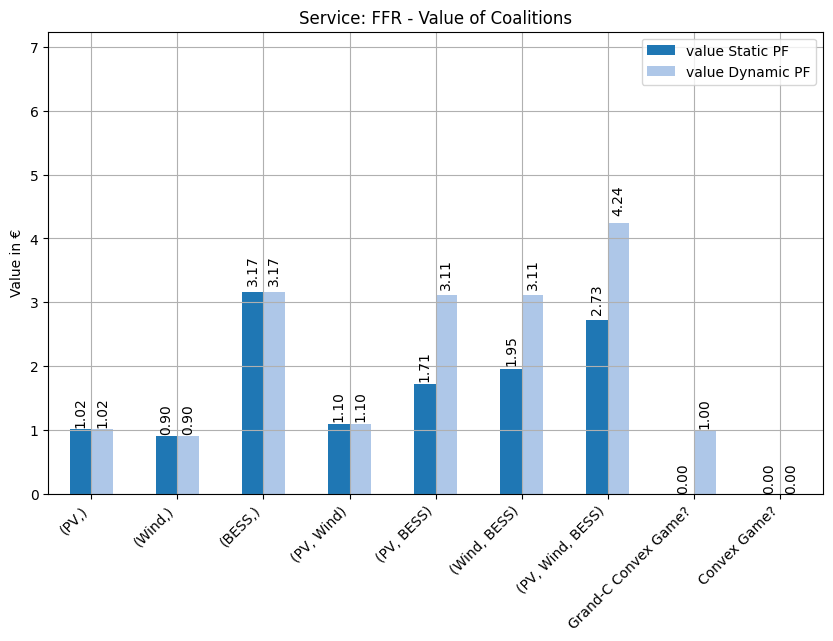

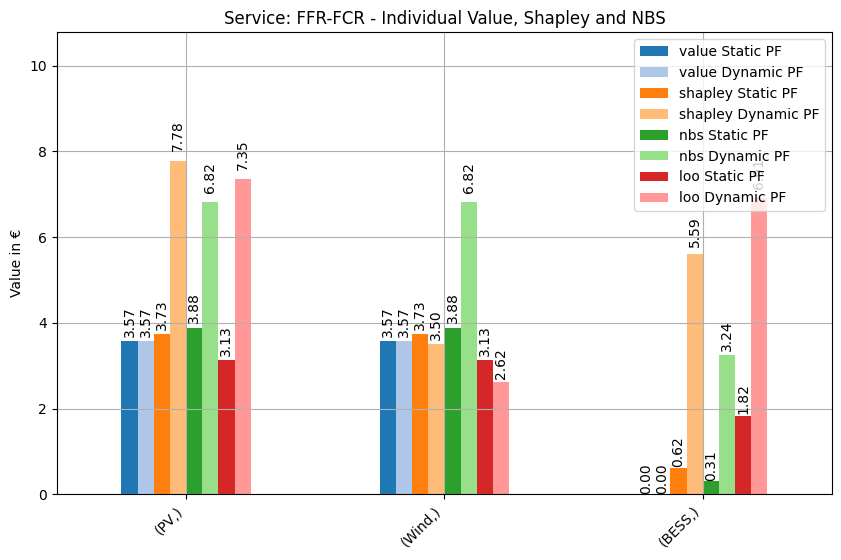

    Grand-Coalition Convexity holds
        Max benefit: 12.50, Min benefit: 1.16
    Grand-Coalition Convexity holds
        Max benefit: 3.70, Min benefit: 2.78
Game is not convex: frozenset({'PV'}), frozenset({'Wind'})
Game is not convex: frozenset({'PV'}), frozenset({'Wind'})


<Figure size 640x480 with 0 Axes>

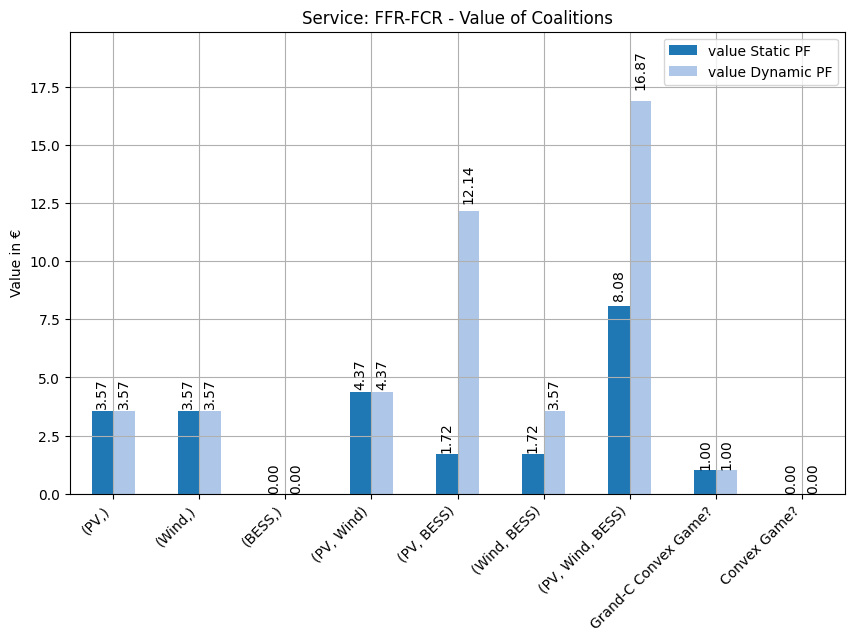

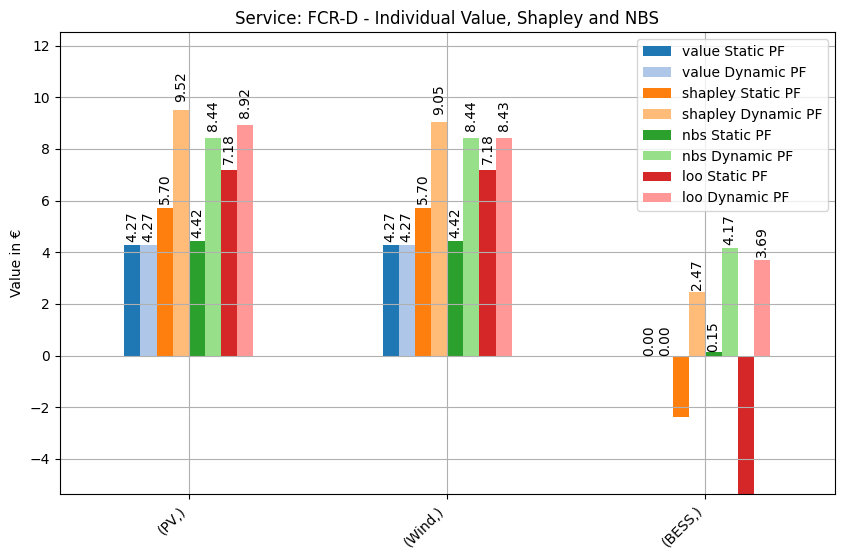

    Grand-Coalition Convexity holds
        Max benefit: 12.50, Min benefit: 6.94
    Game is not Grand-Coalition convex: frozenset({'BESS'}), frozenset({'PV', 'Wind'}), diff=-5.09
Game is not convex: frozenset({'PV'}), frozenset({'BESS'})


<Figure size 640x480 with 0 Axes>

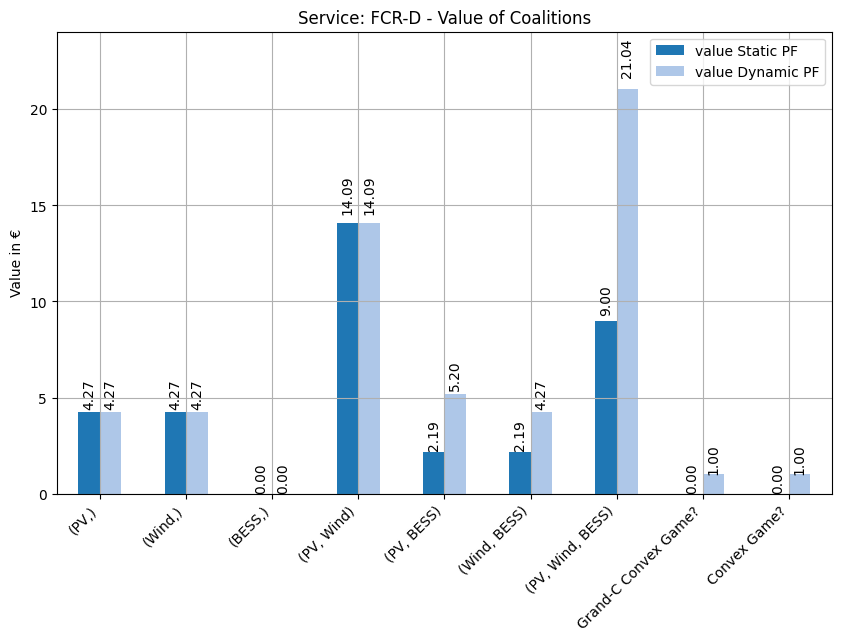

In [220]:
visualize_value_results(df_new, df_newstat)

## compare scenarios

<Figure size 640x480 with 0 Axes>

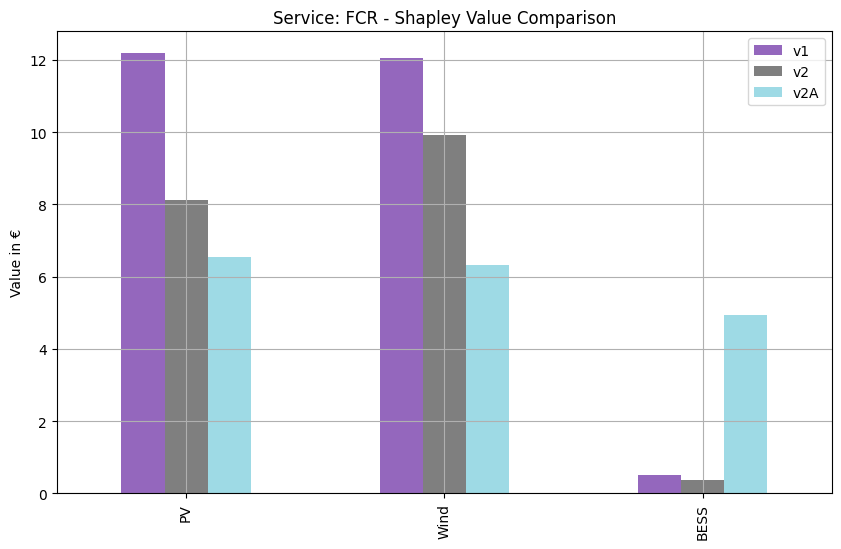

<Figure size 640x480 with 0 Axes>

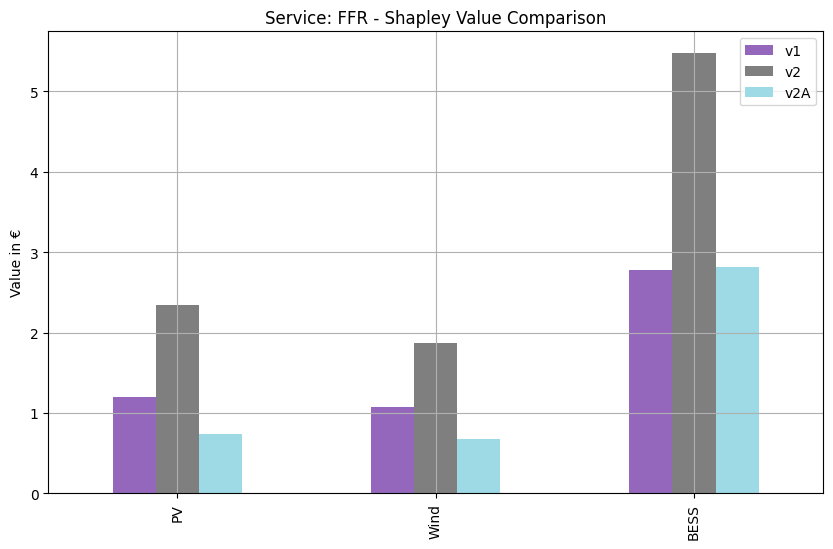

<Figure size 640x480 with 0 Axes>

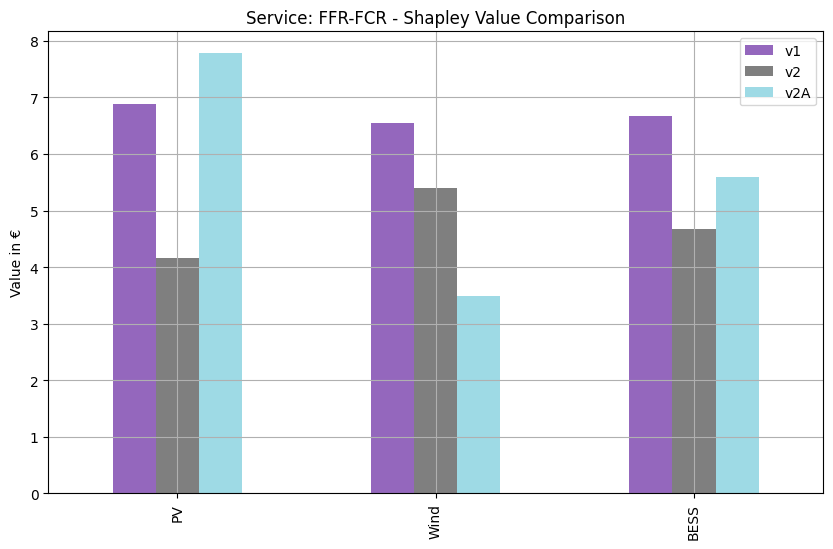

<Figure size 640x480 with 0 Axes>

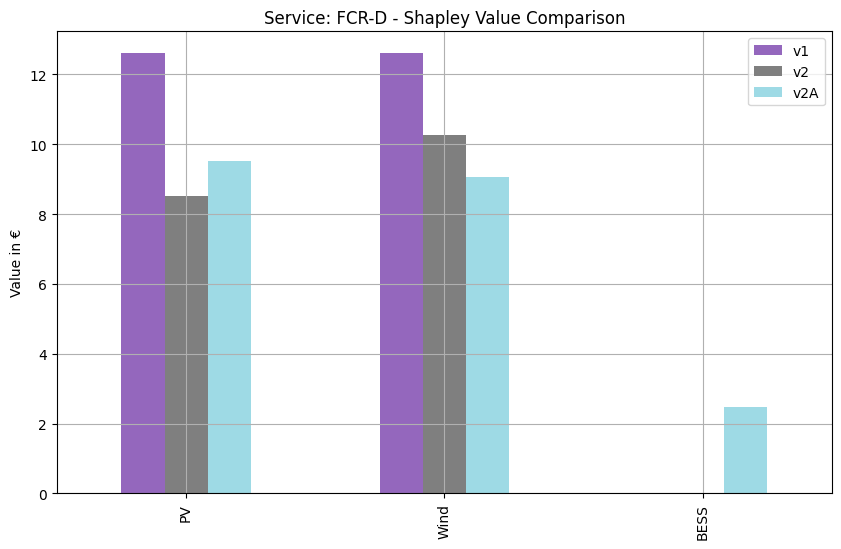

In [336]:
dfs = [df_v1, df_v2, df_v2A]
cases = ['v1', 'v2', 'v2A']
names = [x[0] for x in df_v1.columns if len(x)==1]
# get new colors
colors = plt.cm.tab20(np.linspace(.4, 1, len(cases)))
# plot to compare shapely value
for service in df_v1.index.get_level_values(0).unique():
    plt.figure()
    df_final = pd.DataFrame(0, index=names, columns=cases, dtype=float)
    for i, df in enumerate(dfs):
        df_plot = df.loc[service].loc['shapley'].dropna().astype(float)
        df_final.loc[:, cases[i]] = df_plot.values
    ax = df_final.plot(kind='bar', figsize=(10, 6),
                    title=f'Service: {service} - Shapley Value Comparison', ylabel='Value in €',
                    color=colors)
    plt.grid()

In [ ]:
# compare V1, V2, V2A for FCR and FFR
dfs = [df_v1, df_v2, df_v2A]
# plot to compare shapely value
for service in df_v1.index.get_level_values(0).unique():
    plt.figure()
    df_final = pd.DataFrame()
    for i, df in enumerate(dfs):
        df_plot = df.loc[service, ['shapley', 'nbs']]
        # drop na cols
        df_plot = df_plot.dropna(axis=1, how='any')
        
        
    df_total = df_total.reindex(sorted(df_total.columns, reverse=True), axis=1)
    ax = df_total.plot(kind='bar', figsize=(10, 6),
                    title=f'Service: {service} - Individual Shapley Value Comparison', ylabel='Value in €')
    
    plt.grid()
    plt.ylim(df_total.min().min(), df_total.max().max()+3)
    plt.xticks(rotation=0)
    # show numbers above bars
    for p in ax.patches:
        if p.get_height() >= 0:
            ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2, 1.03 * p.get_height()),
                        ha='center', va='bottom', rotation=90, fontsize=10)
    plt.xticks(rotation=45, ha='right')
    plt.show()

(PV,)   (Wind,)   (BESS,) (PV, Wind) (PV, BESS)  \
FCR     value     3.57479   3.57479       0.0   11.31588   12.13886   
        shapley  6.545212  6.313747  4.937842        NaN        NaN   
        nbs      7.123863  7.123863  3.549073        NaN        NaN   
        loo      5.965691  5.514497  6.316612        NaN        NaN   
FFR     value     1.01517   0.89878   3.16838    1.09923    3.11018   
        shapley  0.739285   0.68109  2.821365        NaN        NaN   
        nbs      0.594875  0.478485   3.16838        NaN        NaN   
        loo      0.887923  0.887923  2.465894        NaN        NaN   
FFR-FCR value     3.57479   3.57479       0.0    4.37205   12.13886   
        shapley   7.77967  3.497635  5.593645        NaN        NaN   
        nbs      6.815247  6.815247  3.240457        NaN        NaN   
        loo      7.348175  2.615208  6.907566        NaN        NaN   
FCR-D   value     4.26917   4.26917       0.0   14.09342    5.19502   
        shapley  9.515632  9.052707  2.468922        NaN        NaN   
        nbs      8.435477  8.435477  4.166307        NaN        NaN   
        loo      8.918268  8.425845  3.693147        NaN        NaN   

                (Wind, BESS) (PV, Wind, BESS)  
FCR     value       11.67593          17.7968  
        shapley          NaN              NaN  
        nbs              NaN              NaN  
        loo              NaN              NaN  
FFR     value        3.11018          4.24174  
        shapley          NaN              NaN  
        nbs              NaN              NaN  
        loo              NaN              NaN  
FFR-FCR value        3.57479         16.87095  
        shapley          NaN              NaN  
        nbs              NaN              NaN  
        loo              NaN              NaN  
FCR-D   value        4.26917         21.03726  
        shapley          NaN              NaN  
        nbs              NaN              NaN  
        loo              NaN              NaN